In [1]:
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
warnings.filterwarnings("ignore", message=r"Implicit", category=UserWarning)
warnings.filterwarnings("ignore", message=r"cannot", category=UserWarning)

In [2]:
import os
import sys
sys.path.append('..')

from carla.recourse_methods import Dice, Wachter
from copy import deepcopy
from model_shifts import (DynamicCsvCatalog,
                          RecourseExperiment,
                          RecourseGenerator,
                          train_model,
                          plot_experiment,
                          generate_gif)

os.environ["CUDA_VISIBLE_DEVICES"] = ""

#     torch.manual_seed(0)
#     random.seed(0)
#     np.random.seed(0)

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [3]:
# Load the dataset from a csv file
dataset = DynamicCsvCatalog(file_path="../datasets/unimodal_dataset_2.csv", 
                            continuous=['feature1', 'feature2'], categorical=[],
                            immutables=[], target='target', test_size=0.3)

[INFO] Balance: train set 0.5, test set 0.5 [dynamic_csv_catalog.py __init__]


In [4]:
hyper_params = {'learning_rate': 0.04, 'epochs': 2, 'batch_size': 1, 'hidden_size': [4]}

# Recourse generated by DICE is compared with the Wachter generator, as they may modify data differently
# we need to keep track of two models and two datasets and update them independently
model = train_model(dataset, hyper_params)

test_parameters = {
  # 'DICE_1': {"num": 1},
  'DICE_2': {"num": 2},
#   'Wachter': {"loss_type": "BCE"}
}

generators = [
              # RecourseGenerator('DICE_1', deepcopy(dataset), deepcopy(model),
              #                   Dice, test_parameters['DICE_1'], hyper_params, 60),
              RecourseGenerator('DICE_2', deepcopy(dataset), deepcopy(model),
                                Dice, test_parameters['DICE_2'], hyper_params, 30),
            #   RecourseGenerator('Wachter', deepcopy(dataset), deepcopy(model),
            #                     Wachter, test_parameters['Wachter'], hyper_params, 1 / 60)
             ]

# SET NAME BEFORE THE EXPERIMENT
name='600_words_experiment'
experiment = RecourseExperiment(dataset, model, generators, name, test_parameters)
experiment.run(total_recourse=0.80, recourse_per_epoch=0.05)
experiment.save_data()

[INFO] Training the initial model [recourse_generator.py train_model]
[INFO] Updating the DICE_2 model [recourse_generator.py update_model]
[INFO] Retraining the model [recourse_generator.py train_model]
[INFO] Current balance: train set 0.5, test set 0.5 [dynamic_mlmodel_catalog.py retrain]
[INFO] Starting epoch 1 [recourse_experiment.py run]
[INFO] Applying the DICE_2 generator. [recourse_generator.py apply_recourse_with_timeout]
[INFO] Int64Index([70], dtype='int64') [recourse_generator.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE_2 [recourse_generator.py apply_recourse_with_timeout]
[INFO]    feature1  feature2  target
0   0.24015  0.710746     1.0 [recourse_generator.py apply_recourse_with_timeout]
[INFO] Int64Index([2], dtype='int64') [recourse_generator.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 2 with DICE_2 [recourse_generator.py apply_recourse_with_timeout]


In [5]:
experiment_path = f'../experiment_data/{experiment.experiment_name}'
for g in test_parameters.keys():
    generate_gif(experiment_path, g)

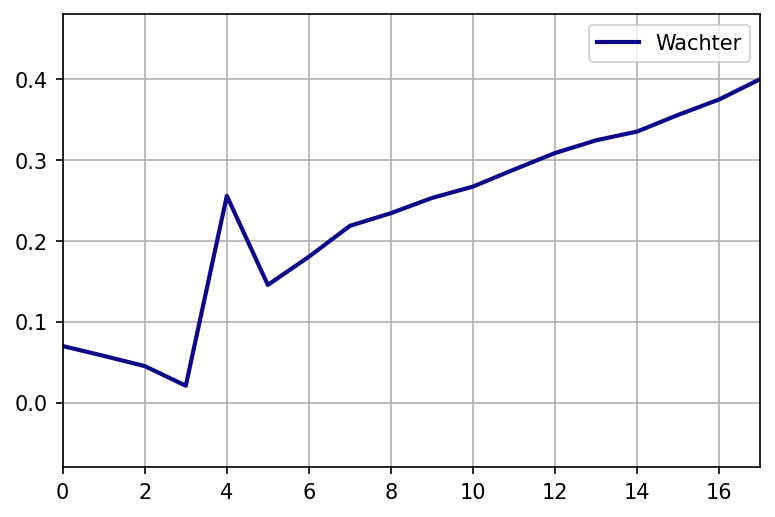

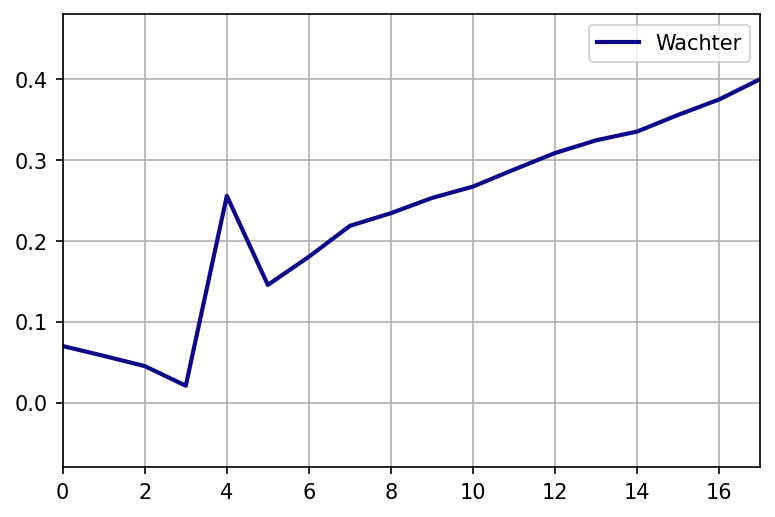

In [6]:
config = {
    'type': 'pos_MMD', 'dict_path': ['MMD', 'positive', 'value'],
    'type': 'neg_MMD', 'dict_path': ['MMD', 'negative', 'value'],
    'type': 'pos_distance', 'dict_path': ['boundary_distance', 'positive'],
    'type': 'neg_distance', 'dict_path': ['boundary_distance', 'negative'],
    'type': 'disagreement', 'dict_path': ['disagreement'],
    'type': 'model_MMD', 'dict_path': ['model_MMD', 'value']
    }

for c in config:
    plot_experiment(experiment_path,
                    [k for k in test_parameters.keys()],
                    config['type'],
                    config['dict_path'])